## Chapter 3
# Transfer learning from MobileNet trained for Imagenet dataset to Cifar10 dataset

In [1]:
import tensorflow as tf
print (tf.__version__)
print (tf.keras.__version__)

1.12.0
2.1.6-tf


In [2]:

# This will download a new version of MobileNet as needed
from tensorflow.keras.applications.mobilenet import MobileNet, decode_predictions

mnet_tfr = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [3]:
for layer in mnet_tfr.layers:
    mnet_tfr.trainable = False

print (len(mnet_tfr.layers))

87


In [4]:
mnet_tfr.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [5]:
from tensorflow.keras.layers import Input, Lambda

# input placeholder for cifar10 32x32x3 images
cifar10_input = Input(shape=(32,32,3))

# resize input (using Keras Lamba layer), attach to input
resized_inp = Lambda(lambda image: tf.image.resize_images(image, (224, 224)))(cifar10_input)

# feed resized images to MobileNet model
inp = mnet_tfr(resized_inp)

In [6]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
avg_pool = GlobalAveragePooling2D()(mnet_tfr.get_output_at(-1))
new_1 = Dropout(rate=0.50)(avg_pool)
new_2 = Dense(1024, activation='relu')(new_1)
estimation = Dense(10, activation='softmax')(new_2)

In [7]:
print (len(mnet_tfr.layers))
mnet_tfr.summary()

87
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_______

In [8]:
# Imports the Model API
from tensorflow.keras.models import Model

# Creates the model
model = Model(inputs=cifar10_input, outputs=estimation)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the summary of this new model to confirm the architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total para

In [11]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_val, y_val) = cifar10.load_data()

# One-hot encode the labels
label_binarizer = LabelBinarizer()
y_one_hot_train = label_binarizer.fit_transform(y_train)
y_one_hot_val = label_binarizer.fit_transform(y_val)

# Shuffle the training & test data
X_train, y_one_hot_train = shuffle(X_train, y_one_hot_train)
X_val, y_one_hot_val = shuffle(X_val, y_one_hot_val)

# For initial experiement let's use only first 5000 images
# And only the first 1,000 images from the validation set
#X_train = X_train[:5000]
#y_one_hot_train = y_one_hot_train[:5000]
#X_val = X_val[:1000]
#y_one_hot_val = y_one_hot_val[:1000]

In [12]:
# Use a generator to pre-process images for MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [16]:
import matplotlib.pyplot as plt
def show_loss_stats(history_object):
    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

In [14]:
# Train the model
batch_size = 128
epochs = 12
hist = model.fit_generator(datagen.flow(X_train, y_one_hot_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs, verbose=1, 
                    validation_data=val_datagen.flow(X_val, y_one_hot_val, batch_size=batch_size),
                    validation_steps=len(X_val)/batch_size)

Epoch 1/12
391/390 [==============================] - 62s 158ms/step - loss: 0.9185 - acc: 0.6844 - val_loss: 0.6150 - val_acc: 0.7987
Epoch 2/12
391/390 [==============================] - 59s 150ms/step - loss: 0.7560 - acc: 0.7344 - val_loss: 0.5656 - val_acc: 0.8095
Epoch 3/12
391/390 [==============================] - 59s 150ms/step - loss: 0.7076 - acc: 0.7515 - val_loss: 0.5480 - val_acc: 0.8090
Epoch 4/12
391/390 [==============================] - 59s 150ms/step - loss: 0.6758 - acc: 0.7624 - val_loss: 0.5469 - val_acc: 0.8176
Epoch 5/12
391/390 [==============================] - 59s 150ms/step - loss: 0.6519 - acc: 0.7687 - val_loss: 0.5326 - val_acc: 0.8224
Epoch 6/12
391/390 [==============================] - 59s 150ms/step - loss: 0.6312 - acc: 0.7798 - val_loss: 0.5263 - val_acc: 0.8240
Epoch 7/12
391/390 [==============================] - 59s 150ms/step - loss: 0.6173 - acc: 0.7849 - val_loss: 0.5225 - val_acc: 0.8238
Epoch 8/12
391/390 [==============================] - 5

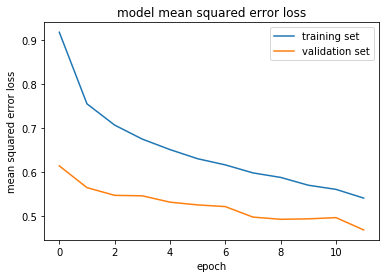

In [17]:
show_loss_stats(hist)